In [12]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import scipy.linalg as linalg
import scipy.optimize as opt
import scipy.sparse as sparse
import scipy.fftpack
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
def bernoulli_matrix_gen(m, n):
    return (stats.bernoulli.rvs(p=1/2, size=(m, n)) * 2 - 1) / m ** 0.5

def gaussian_matrix_gen(m, n):
    return stats.norm.rvs(loc=1/m, size=(m, n))

def mean_matrix_gen(m, n):
    a = np.zeros((m, n))
    div = n // m
    for i in range(m):
        a[i, i * div : (i + 1) * div] = 1
    a[-1, (i + 1) * div:] = 1
    return a

def chipping_matrix_gen(m, n):
    return mean_matrix_gen(m, n) @ np.diag(stats.bernoulli.rvs(p=1/2, size=n) * 2 - 1)

def random_columns_matrix_gen(m, n):
    a = np.identity(n)
    perm = np.arange(n)
    np.random.shuffle(perm)
    a[perm] = a[np.arange(n)]
    return a[:m]

def random_fourier_columns_matrix_gen(m, n):
    a = np.identity(n)
    perm = np.arange(n)
    np.random.shuffle(perm)
    a[perm] = sp.fftpack.dct(a[np.arange(n)], norm='ortho')
    return a[:m]

def not_random_matrix_gen(m, n):
    np.random.seed(0)
    a = np.zeros(m * n, dtype=np.int)
    p = 10**9 + 7
    seed = np.random.randint(1, p - 1)
    for i in range(m * n):
        a[i] = pow(seed, i, p) % 2
    return a.reshape((m, n))

def checktable(m, n):
    a = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            a[i, j] = (i + j) % 2
    return a

In [3]:
def gen_sparse(n, k):
    x = np.random.rand(n)
    random_mask = np.concatenate((np.zeros(n - k), np.ones(k)))
    np.random.shuffle(random_mask)
    return x * random_mask

def gen_noised(n, k, eps):
    return gen_sparse(n, k) + stats.norm.rvs(size=n) * eps

def gen_compressive(n, k):
    perm = np.arange(n)
    np.random.shuffle(perm)
    x = np.arange(1, n + 1) ** (-n / k / 4)
    return x[perm]

In [4]:
def decompress_sparse(a, y, tol=1e-8):
    m, n = a.shape
    A_eq = np.zeros((m, 2 * n))
    A_eq[:, :n] = a

    A_ub = np.zeros((2 * n, 2 * n))
    A_ub[:n, :n] = np.identity(n)
    A_ub[:n, n:] = -np.identity(n)
    A_ub[n:, :n] = -np.identity(n)
    A_ub[n:, n:] = -np.identity(n)
    b_ub = np.zeros(2 * n)
    bounds=np.array([(None, None)] * n + [(0, None)] * n)
    c = np.zeros(2 * n)
    c[n:] = 1
    b_eq = y
    res = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, 
                      #options={'maxiter': 10000, 'disp': False, 'tol': tol})
                      method='interior-point', options={"tol" : tol, "sym_pos" : False})
    if not res.success:
        raise Exception(res)
    return res.x[0 : n]

In [5]:
def decompress_approx_1(a, y, eps, tol):
    m, n = a.shape

    A_ub = np.zeros((2 * m + 2 * n, 2 * n))
    A_ub[:m, :n] = a
    A_ub[m : 2 * m, :n] = -a
    A_ub[2 * m : 2 * m + n, :n] = np.identity(n)
    A_ub[2 * m : 2 * m + n, n:] = -np.identity(n)
    A_ub[2 * m + n :, :n] = -np.identity(n)
    A_ub[2 * m + n :, n:] = -np.identity(n)
    b_ub = np.zeros(2 * m + 2 * n)
    b_ub[: m] = y + 2 * eps
    b_ub[m : 2 * m] = -y + 2 * eps
    bounds=np.array([(None, None)] * n + [(0, None)] * n)
    c = np.zeros(2 * n)
    c[n:] = 1
    res = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, 
                      #options={'maxiter': 10000, 'disp': False, 'tol': tol})
                      method='interior-point', options={'maxiter': 10000, "tol" : tol, "sym_pos" : False})
    if not res.success:
        raise Exception(res)
    x = res.x[0 : n]
    x[np.abs(x) < eps] = 0
    return x

In [7]:
def decompress_approx_2(a, y, eps, tol):
    m, n = a.shape
    
    u, s, vh = linalg.svd(a, full_matrices=False)

    A_ub = np.zeros((2 * m + 2 * n, 2 * n))
    A_ub[:m, :n] = np.diag(s) @ vh
    A_ub[m : 2 * m, :n] = -np.diag(s) @ vh
    A_ub[2 * m : 2 * m + n, :n] = np.identity(n)
    A_ub[2 * m : 2 * m + n, n:] = -np.identity(n)
    A_ub[2 * m + n :, :n] = -np.identity(n)
    A_ub[2 * m + n :, n:] = -np.identity(n)
    b_ub = np.zeros(2 * m + 2 * n)
    b_ub[: m] = linalg.inv(u) @ y + eps * s * 2
    b_ub[m : 2 * m] = -linalg.inv(u) @ y + eps * s * 2
    bounds=np.array([(None, None)] * n + [(0, None)] * n)
    c = np.zeros(2 * n)
    c[n:] = 1
    res = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, 
                      #options={'maxiter': 10000, 'disp': False, 'tol': tol})
                      method='interior-point', options={'maxiter': 10000, "tol" : tol, "sym_pos" : False})
    if not res.success:
        raise Exception(res)
    x = res.x[0 : n]
    x[x < 2 * eps] = 0
    return x

In [8]:
def estimate_feasibility(n, m, matrix_gen, vector_gen, params, decompress):
    a = matrix_gen(m, n)
    x = vector_gen(n, **params)
    y = a @ x
    try:
        x0 = decompress(a, y)
    except Exception as e:
        return np.linalg.norm(x)
    return np.linalg.norm(x - x0)

In [9]:
def find_m(n, matrix_gen, vector_gen, params, decompress, ok_crit, iters):
    l, r = 0, n
    while l + 1 != r:
        m = (l + r) // 2
        err = 0
        for _ in range(iters):
            err += estimate_feasibility(n, m, matrix_gen, vector_gen, params, decompress)
        if ok_crit(err / iters):
            r = m
        else:
            l = m
    return r

In [14]:
d = dict()
n = 50
while n < 100:
    d[n] = dict()
    k = 1
    while k < n // 3:
        m = find_m(n=n, 
           matrix_gen=random_fourier_columns_matrix_gen, 
           vector_gen=lambda n, k: gen_sparse(n, k), 
           params={"k" : k}, 
           decompress=decompress_sparse,
           ok_crit=lambda x : x < 1e-9,
           iters=5
        )
        print(n, k, m, sep='\t')
        d[n][k] = m
        if m >= n // 2:
            break
        k = int(k * 1.1) + 1
    n = int(n * 1.1)

50	1	6
50	2	26
55	1	5
55	2	11
55	3	20
55	4	18
55	5	35
60	1	6
60	2	11
60	3	16
60	4	19
60	5	24
60	6	20
60	7	28
60	8	30
66	1	8
66	2	11
66	3	15
66	4	22
66	5	20
66	6	16
66	7	30
66	8	34
72	1	8
72	2	10
72	3	13
72	4	20
72	5	23
72	6	39
79	1	7
79	2	13
79	3	16
79	4	19
79	5	32
79	6	35
79	7	29
79	8	45
86	1	6
86	2	13
86	3	22
86	4	21
86	5	22
86	6	29
86	7	26
86	8	32
86	9	49
94	1	9
94	2	12
94	3	18
94	4	24
94	5	30
94	6	37
94	7	35
94	8	38
94	9	39
94	10	44
94	12	59


In [15]:
flattened = []
for n in d:
    for k in d[n]:
        flattened.append((n, k, d[n][k]))

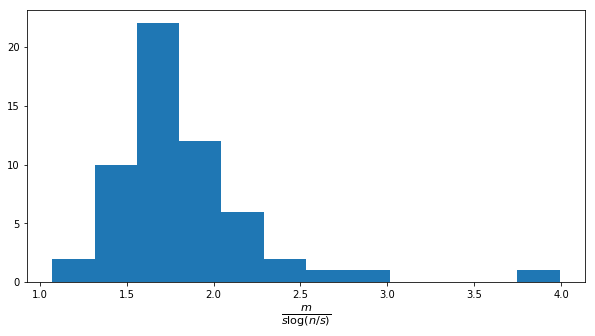

In [18]:
m = np.array([i[2] for i in flattened])
klognk = np.array([i[1] * np.log(i[0] / i[1] + 1) for i in flattened])
plt.figure(figsize=(10, 5))
plt.hist(m / klognk, bins=12)
_ = plt.xlabel("$\\frac{m}{s \\log(n/s)}$")
_.set_fontsize(16)
#plt.legend()
#plt.savefig("fourier.pdf")

In [29]:
d = dict()
n = 50
while n < 70:
    d[n] = dict()
    k = 1
    while k < n // 3:
        eps = 1 / n / 3
        m0 = find_m(n=n, 
           matrix_gen=bernoulli_matrix_gen, 
           vector_gen=lambda n, k: gen_noised(n, k, eps), 
           params={"k" : k}, 
           decompress=lambda a, y: decompress_sparse(a, y, eps),
           ok_crit=lambda x : x < eps * n,
           iters=5
          )
        m1 = find_m(n=n, 
           matrix_gen=bernoulli_matrix_gen, 
           vector_gen=lambda n, k: gen_noised(n, k, eps), 
           params={"k" : k}, 
           decompress=lambda a, y: decompress_approx_1(a, y, eps, eps),
           ok_crit=lambda x : x < eps * n,
           iters=5
          )
        m2 = find_m(n=n, 
           matrix_gen=bernoulli_matrix_gen, 
           vector_gen=lambda n, k: gen_noised(n, k, eps), 
           params={"k" : k}, 
           decompress=lambda a, y: decompress_approx_2(a, y, eps, eps),
           ok_crit=lambda x : x < eps * n,
           iters=5
          )
        print(n, k, m0, m1, m2, sep='\t')
        d[n][k] = m0
        if m0 >= n // 2:
            break
        k = int(k * 1.1) + 1
    n = int(n * 1.1)

50	1	5	7	7
50	2	8	9	10
50	3	10	12	11
50	4	15	15	15
50	5	16	16	19
50	6	19	19	15
50	7	22	21	19
50	8	23	21	20
50	9	23	25	24
50	10	29	25	24
55	1	7	4	7
55	2	10	10	8
55	3	12	14	11
55	4	14	14	13
55	5	13	18	17
55	6	18	20	18
55	7	22	21	23
55	8	26	24	21
55	9	26	24	24
55	10	25	27	27
55	12	32	27	31
60	1	5	7	5
60	2	9	11	9
60	3	9	12	13
60	4	13	14	11
60	5	17	15	16
60	6	19	21	17
60	7	23	21	20
60	8	23	25	24
60	9	26	27	26
60	10	31	31	28
66	1	8	8	6
66	2	9	10	10
66	3	12	14	11
66	4	15	14	17
66	5	18	17	17
66	6	19	18	21
66	7	22	23	25
66	8	24	25	23
66	9	25	26	27
66	10	31	31	28
66	12	28	33	34
66	14	33	36	36
